In [1]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def centerRotateScale(lon,lat,lonCenter=0,latCenter=0,rotationAngle=0,scale=1):
    '''
    Takes longitudes in terms of vertical numpy matrix and 
    latitude in terms of a vertical numpy matrix
    Re-centers at lonCenter and latCenter
    Rotates the coordinate sstem by rotationangle (in degrees)
    scales the final results by the scale
    '''
    #Center
    M = np.concatenate((lon-lonCenter, lat-latCenter), axis=1)
    #Make rotation matrix then rotate
    theta = math.radians(rotationAngle)
    R = np.matrix([[math.cos(theta), -1*math.sin(theta)],
                  [math.sin(theta), math.cos(theta)]])
    M = R*M.transpose()
    M.transpose()
    #Scale the values
    M = M*scale
    return M[0,:], M[1,:]
#Center the latitude and longitude around the bottom left of manhattan
#(40.7083,-74.0520)


In [4]:
def plotMapBox(pickupx,pickupy,dropoffx,dropoffy,deltax,deltay,limits=True):
    '''Plot the map of pickups(red) and dropoffs(blue)
    pickup/dropoff-x/y are lists of some sort
    deltax/y = [min,max] of the bounding box
    limits=True constrains the plot limits
    '''
    #Prepare the box simensions
    boxx = [deltax[0],deltax[0],deltax[1],deltax[1],deltax[0]]
    boxy = [deltay[0],deltay[1],deltay[1],deltay[0],deltay[0]]
    #Establish the figure
    fig=plt.figure(figsize=(8, 8)) #Change this to increase or decrease the size of the figures
    plt.axis('equal')
    #Plot the points
    plt.plot(pickupx,pickupy,color='b',marker=',',lw=0, linestyle="")
    plt.plot(dropoffx,dropoffy,color='r',marker=',',lw=0, linestyle="")
    plt.plot(boxx,boxy,'k')
    if limits==True:
        #Determine the boarder width
        borderx = 0.125*abs(deltax[0]-deltax[1])
        bordery = 0.125*abs(deltay[0]-deltay[1])
        #Set the limits
        plt.xlim([deltax[0]-borderx,deltax[1]+borderx])
        plt.ylim([deltay[0]-bordery,deltay[1]+bordery])

In [5]:
#Master function to do the partitioning for this step
def partitionXY(inputFilePath,outputFilePath,makePlots=True):
    '''
    Rotate the project by (see variables below)
    Translate into XY coordinates which are in 100s of hours of latitude or longitude
    Create a bounding box for data to be considered (see variables below)
    Partition the data in the bounding box
    Save the new data to a csv file at outputFilePath
    '''
    #Import the data file as a data frame
    df = pandas.read_csv(inputFilePath)
    print('Base Data File:')
    print(df.iloc[0:2])
    print('Number of data points: '+str(len(df)))
    print('')
    
    #Center the latitude and longitude around times square
    lonCenter=-73.985101
    latCenter=40.759080
    rotationAngle=36
    scale=100
    #Rotate the graph by 29 degrees, because that is the angle of manhattan
    lon = df.as_matrix(['pickup_longitude'])
    lat = df.as_matrix(['pickup_latitude'])
    px,py = centerRotateScale(lon,lat,lonCenter,latCenter,rotationAngle,scale)
    #Rotate the graph by 29 degrees, because that is the angle of manhattan
    lon = df.as_matrix(['dropoff_longitude'])
    lat = df.as_matrix(['dropoff_latitude'])
    dx,dy = centerRotateScale(lon,lat,lonCenter,latCenter,rotationAngle,scale)
    
    #Define the bounding box
    deltax = [-1.5,2.5]
    deltay = [-6.4,8]
    #Plot Progress so far
    if makePlots==True:
        print('Origional Data with Bounding Box:')
        plotMapBox(pickupx=px.tolist()[0],pickupy=py.tolist()[0],
                   dropoffx=dx.tolist()[0],dropoffy=dy.tolist()[0],
                   deltax=deltax,deltay=deltay,limits=True)
        plt.show()
        print('')

    #Set the real x=0 and y=0 to the bottom corner of the bounding box
    #Save the x and the y to the data frame
    df['pickup_x'] = (px - deltax[0]).tolist()[0]
    df['pickup_y'] = (py - deltay[0]).tolist()[0]
    df['dropoff_x'] = (dx - deltax[0]).tolist()[0]
    df['dropoff_y'] = (dy - deltay[0]).tolist()[0]
    #Find the length and the width of the bounding box
    maxx = deltax[1] - deltax[0]
    maxy = deltay[1] - deltay[0]
    
    #Partition the data so that only only orgins and destinations in the city are considered
    #Throw away the latitude and longitude data
    dfBoxed = df.loc[:,['pickup_x','pickup_y','dropoff_x','dropoff_y']]
    #Start with x
    dfBoxed = dfBoxed.loc[df['pickup_x']>=0]
    dfBoxed = dfBoxed.loc[dfBoxed['pickup_x']<=maxx]
    dfBoxed = dfBoxed.loc[dfBoxed['dropoff_x']>=0]
    dfBoxed = dfBoxed.loc[dfBoxed['dropoff_x']<=maxx]
    #Then box the y direction
    dfBoxed = dfBoxed.loc[df['pickup_y']>=0]
    dfBoxed = dfBoxed.loc[dfBoxed['pickup_y']<=maxy]
    dfBoxed = dfBoxed.loc[dfBoxed['dropoff_y']>=0]
    dfBoxed = dfBoxed.loc[dfBoxed['dropoff_y']<=maxy]     
    
    print('Boxed Data:')
    print(dfBoxed.iloc[0:2])
    print('Number of data points: '+str(len(dfBoxed)))
    print('')
    
    #Plot Progress so far
    if makePlots==True:
        print('Boxed Data:')
        plotMapBox(pickupx=dfBoxed['pickup_x'],pickupy=dfBoxed['pickup_y'],
                   dropoffx=dfBoxed['dropoff_x'],dropoffy=dfBoxed['dropoff_y'],
                   deltax=[0,maxx],deltay=[0,maxy],limits=True)
        plt.show()
        print('')
    
    #Save as new csv file
    dfBoxed.to_csv(outputFilePath)

---------------------------------------------
RUSH HOUR DATA

Base Data File:
   Unnamed: 0  pickup_longitude  pickup_latitude  dropoff_longitude  \
0     3220302        -73.984283        40.729012         -74.001923   
1     3220303        -73.955917        40.764046         -73.975967   

   dropoff_latitude  
0         40.721500  
1         40.765697  
Number of data points: 80958

Origional Data with Bounding Box:


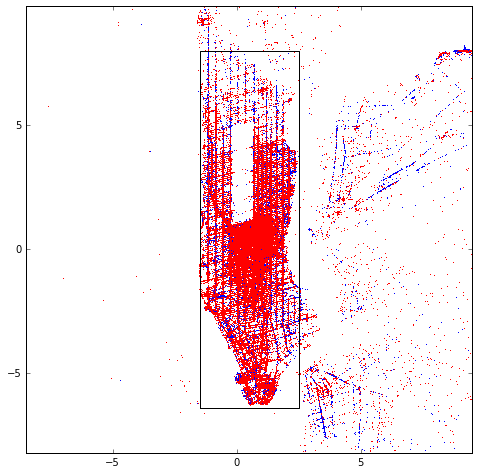


Boxed Data:
   pickup_x  pickup_y  dropoff_x  dropoff_y
0  3.333521  4.015465   2.347977   2.370997
1  3.569129  8.517106   1.849958   7.472224
Number of data points: 70963

Boxed Data:


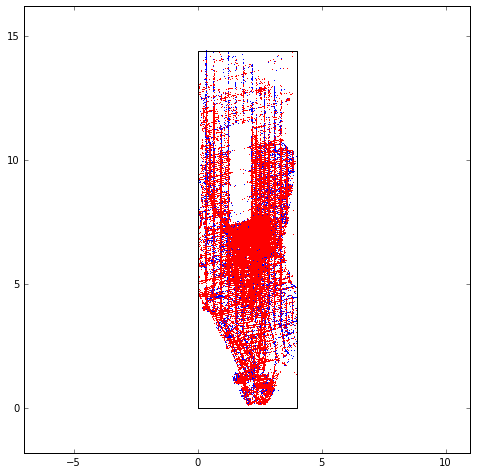


---------------------------------------------
WEEKEND HOUR DATA

Base Data File:
   Unnamed: 0  pickup_longitude  pickup_latitude  dropoff_longitude  \
0     1504109        -73.996704        40.720528         -73.999062   
1     1504110        -73.984215        40.728851         -73.987534   

   dropoff_latitude  
0         40.734329  
1         40.740757  
Number of data points: 79642

Origional Data with Bounding Box:


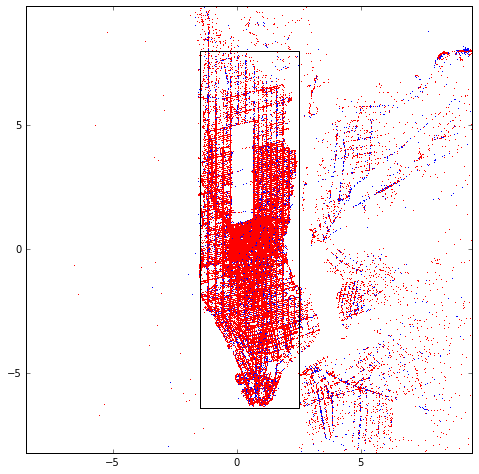


Boxed Data:
   pickup_x  pickup_y  dropoff_x  dropoff_y
0  2.827340  2.599036   1.825379   3.577038
1  3.348494  4.006539   2.380201   4.774654
Number of data points: 68040

Boxed Data:


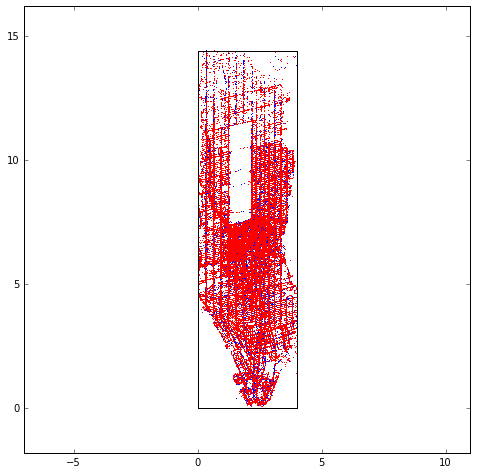

In [6]:
#Apply the operations to the rush hour data
print('---------------------------------------------')
print('RUSH HOUR DATA')
print('')
partitionXY(inputFilePath='rushhr_coordinates.csv',
            outputFilePath='rushhr_xy.csv',
            makePlots=True)

#Apply the operations for the weekend data
print('---------------------------------------------')
print('WEEKEND HOUR DATA')
print('')
partitionXY(inputFilePath='weekendhr_coordinates.csv',
            outputFilePath='weekendhr_xy.csv',
            makePlots=True)

# Information on Output File
The output file has the city rotated such that the N-S strees are parallel to the y axis. The x and y units in the file are in 100s of longitudes or latitudes... so you can figure out what that means